<a href="https://colab.research.google.com/github/FauxGrit/Soccer-Graph-Analytics/blob/main/World_Cup_Graph_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsbombpy
!pip install install networkx==1.11
!pip install matplotlib==2.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import networkx as nx             ## version 1.11
from collections import Counter
import matplotlib.pyplot as plt   ## version 2.2.3

import warnings
warnings.filterwarnings('ignore')

# Load Data
Use API to access free soccer data from Statsbomb.

Statsbomb documentation is available at https://github.com/statsbomb/statsbombpy

Find competition_id and season_id for FIFA World Cup. Results filtered to only the applicable row for illustration purposes.

In [3]:
sb.competitions().iloc[[18]]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,3,International,FIFA World Cup,male,False,True,2018,2022-09-05T17:17:56.670896,2021-06-13T16:17:31.694,None,2022-09-05T17:17:56.670896


Use Statsbomb API to build a dataframe of all passes from the 2018 World Cup. The API calls will take a little time to execute.

In [4]:
# Generate list of matches from 2018 World Cup
matches_list = sb.matches(competition_id=43, season_id=3)['match_id'].tolist()

# Use Statsbomb API to return events from all World Cup matches
for count, id in enumerate(matches_list):
    if count==0:
        events = sb.events(match_id=id)
    else:
        # print("Match Count: ", count)
        events = events.append(sb.events(match_id=id), ignore_index=True)
        
# Filter events to retain only regular play passes
passes = events.loc[(events['type'] == 'Pass') & (events['play_pattern'] == 'Regular Play')]
        
# Convert location data from arrays into coordinates
passes['x'] = passes.apply(lambda n: n['location'][0] , axis=1)
passes['y'] = passes.apply(lambda n: n['location'][1] , axis=1)
passes['pass_end_x'] = passes.apply(lambda n: n['pass_end_location'][0] , axis=1)
passes['pass_end_y'] = passes.apply(lambda n: n['pass_end_location'][1] , axis=1)

# Filter columns to those relevant to passes
passes = passes[['duration','id',
       'match_id','x','y','pass_end_x','pass_end_y',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_backheel', 'pass_body_part', 'pass_cross', 'pass_cut_back',
       'pass_goal_assist', 'pass_height', 'pass_length',
       'pass_outcome', 'pass_recipient', 'pass_shot_assist', 'pass_switch',
       'pass_type', 'player', 'player_id','play_pattern',
       'position', 'possession_team', 'possession_team_id',
       'related_events', 'team', 'type']].reset_index(drop=True)

# convert player_id data type (float) into integer
passes['player_id'] = passes['player_id'].astype(int)

# Inspect last 5 records
passes.tail()

,duration,id,match_id,x,y,pass_end_x,pass_end_y,pass_aerial_won,pass_angle,pass_assisted_shot_id,...,pass_type,player,player_id,play_pattern,position,possession_team,possession_team_id,related_events,team,type
34505,0.520,9c9d3bbb-fecb-4e35-9399-d9fc2ba89e05,7559,98.0,63.0,96.0,58.0,NaN,-1.951303,NaN,...,NaN,Abdullah Ibrahim Otayf,5173,Regular Play,Center Defensive Midfield,Saudi Arabia,799,[0511025f-56ec-4e35-841e-0af7f5fe71c5],Saudi Arabia,Pass
34506,0.920,91040326-ba0b-4256-9ade-779d87140cfd,7559,96.0,58.0,108.0,65.0,NaN,0.528074,NaN,...,NaN,Salem Mohammed Al Dawsari,5187,Regular Play,Center Attacking Midfield,Saudi Arabia,799,[9dff0b44-d012-4beb-93f4-7a1166fd4aa9],Saudi Arabia,Pass
34507,1.120,32e32ab3-399f-45bb-8cf7-137561fa4bb6,7559,108.0,65.0,116.0,59.0,NaN,-0.643501,NaN,...,NaN,Abdullah Ibrahim Otayf,5173,Regular Play,Center Defensive Midfield,Saudi Arabia,799,[3dcb2cf6-4c71-4240-8c3f-4c73823e6859],Saudi Arabia,Pass
34508,0.799,80074b66-b52d-4c77-a2fc-f7b05a6b2f1a,7559,112.0,68.0,109.0,52.0,NaN,-1.756144,NaN,...,Recovery,Mohammed Al Burayk,5191,Regular Play,Right Back,Saudi Arabia,799,[60d1d4cb-bd0b-4e42-9c9a-23f898ddc3d1],Saudi Arabia,Pass
34509,1.120,6d253759-f172-403a-b211-ccb5ea7b7cdf,7559,107.0,53.0,115.0,53.0,NaN,0.000000,f716b964-5b80-4866-b448-c81985baa6a1,...,NaN,Abdullah Ibrahim Otayf,5173,Regular Play,Center Defensive Midfield,Saudi Arabia,799,[b266967b-5518-4802-8f15-38b4e848db3a],Saudi Arabia,Pass


# Create Graph Metrics

### Team Metrics
- **Density:** Provide a sense of how close a network is. Density is the ratio of actual edges in the network to all possible edges in the network.
- **Diameter:** Provides a sense of the network’s overall size, the distance from one end of the network to another. This is the longest of all shortest paths.
- **Triadic Closure / Transitivity:** Transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Triadic closure supposes that if two people know the same person, they are likely to know each other. 

###  Network Metrics by Player
- **Closeness Centrality:** *Indicates how close a player is to all other players.*  Avg of shortest path length from given player to all other players.
- **Betweenness Centrality:** *Measures how important a player is to the shortest paths through the network.*  To compute betweenness for a node N, we select a pair of nodes and find all the shortest paths between those nodes. Then we compute the fraction of those shortest paths that include node N. If there were five shortest paths between a pair of nodes, and three of them went through node N, then the fraction would be 3÷5=0.6. We repeat this process for every pair of nodes in the network. We then add up the fractions we computed, and this is the betweenness centrality for node N.
- **Eigenvector centrality:** *a more sophisticated view of centrality.* a player with few connections could have a very high eigenvector centrality if those few connections were to other very well-connected players.



### Graph Theory Prep

Prep for calculcating team and player graph metrics.

In [5]:
# Build a list of all teams
teams_list = passes['team'].unique().tolist()
#print(all_teams)

# Create blank dataframe for team and player metrics
team_metrics = pd.DataFrame(columns=['team', 'density', 'transitivity', 
                                     'avg goals', 'avg goals conceded', 
                                     'avg point diff'])

player_metrics = pd.DataFrame(columns=['team', 'player', 'degree', 'closeness', 
                                       'betweenness', 'ev_centrality' ])

# Prepare dictionary of avg goals for and against each team (manually created from official scores)
avg_goals_for = {'Australia': .67, 'Peru':.67, 'Iceland':.67, 'Nigeria':1.0, 
                 'Brazil':1.6, 'Serbia':.67, 'Denmark':.75, 'Croatia':2., 
                 'Portugal':1.5, 'Iran':.67, 'Sweden':1.2, 'Mexico':.75, 
                 'Costa Rica':.67, 'Germany':.67, 'Spain':1.75, 'Russia':2.2, 
                 'Egypt':.67, 'Switzerland':1.25, 'Tunisia':1.67, 'Panama':.67, 
                 'Belgium':2.29, 'England':1.71, 'France':2.0, 'Uruguay':1.4, 
                 'Argentina':1.5, 'Japan':1.5, 'South Korea':1., 'Morocco':.67, 
                 'Saudi Arabia':.67, 'Colombia':1.5, 'Poland':.67, 
                 'Senegal':1.33}

avg_goals_against = {'Australia': 1.67, 'Peru':.67, 'Iceland':1.67, 
                     'Nigeria':1.33, 'Brazil':.6, 'Serbia':1.33, 'Denmark':.5, 
                     'Croatia':1.29, 'Portugal':1.5, 'Iran':.67, 'Sweden':.8, 
                     'Mexico':1.5, 'Costa Rica':1.67, 'Germany':1.33, 
                     'Spain':1.5, 'Russia':1.4, 'Egypt':2.0, 'Switzerland':1.25, 
                     'Tunisia':2.67, 'Panama':3.67, 'Belgium':.86, 
                     'England':1.14, 'France':0.86, 'Uruguay':.6, 
                     'Argentina':2.25, 'Japan':1.75, 'South Korea':1., 
                     'Morocco':1.33, 'Saudi Arabia':2.33, 'Colombia':.75, 
                     'Poland':1.67, 'Senegal':1.33}

# Dictionary used in shading nodes (lighter to darker from backs, to midfield, to forwards)
position_dict = {'Goalkeeper':1, 'Right Back':10, 'Right Center Back':10, 
                 'Center Back':10, 'Left Center Back': 10, 'Left Back':10, 
                 'Right Wing Back':10, 'Left Wing Back':10, 
                 'Right Defensive Midfield':15, 'Center Defensive Midfield':15, 
                 'Left Defensive Midfield':15, 'Right Midfield':15, 
                 'Right Center Midfield':15, 'Center Midfield':15,
                 'Left Center Midfield':15, 'Left Midfield':15, 'Right Wing':25, 
                 'Right Attacking Midfield':15, 'Center Attacking Midfield':15, 
                 'Left Attacking Midfield':15, 'Left Wing':25, 
                 'Right Center Forward':25, 'Center Forward':25,
                  'Left Center Forward':25, 'Secondary Striker':30}

### Build Graphs & Calculate Metrics

Build pass graphs and metrics for each team and player. Some teams have disconnected graphs. This creates errors when calculating diameter. So not calculating diameter.  

The NetworkX python library is used to easily build graphs and calculate graph metrics. NetworkX documentation is available at https://networkx.org/documentation/stable/index.html.

In [6]:
for team in teams_list:
    
    # create passing df for a given team
    team_df = passes[passes.team.eq(team)]
    #print("Full Count:", len(team_df.index))
    
    # drop rows with blank pass recepient
    team_df['pass_recipient'].replace('', np.nan, inplace=True)
    team_df.dropna(subset=['pass_recipient'], inplace=True)
    #print("New Count:", len(team_df.index))
    
    # create list of all edges for given team
    edges = []
    for index, row in team_df.iterrows():
        edges.append((row.player, row.pass_recipient))
        
    # create graph from edges list
    graph = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())
    #print(*graph.edges(data=True), sep='\n')
    
    #Append to team table
    team_metrics = team_metrics.append({
                    'team' : team, 'density' : nx.density(graph), 'transitivity': nx.transitivity(graph),
                    'avg goals':avg_goals_for[team] , 
                    'avg goals conceded':avg_goals_against[team] , 
                    'avg point diff': avg_goals_for[team] - avg_goals_against[team]}, ignore_index=True)
    
    # Append player metrics
    for player in list(graph.nodes()):
        player_metrics = player_metrics.append({
                    'team' : team, 'player' : player, 'degree' : graph.degree(player), 
                    'closeness': nx.closeness_centrality(graph)[player], 
                    'betweenness': nx.betweenness_centrality(graph)[player], 
                    'ev_centrality': nx.eigenvector_centrality(graph)[player]}, ignore_index=True)
        
# print("Team Metrics:\n", team_metrics.head())
# print("\n\nPlayer Metrics:\n", player_metrics.head())

### Pearson Coefficient of Correlation Heatmap
Build heatmap to identify graph metrics that most correlate with team performance. From the plot we see that transitivity and avg point difference have the highest correlation.

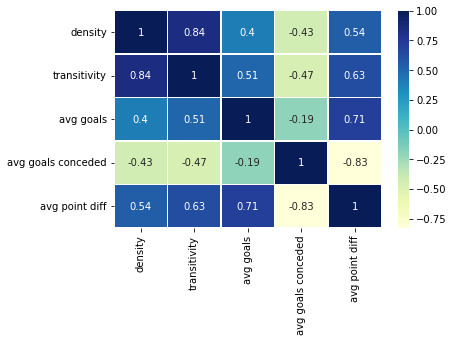

In [7]:
import seaborn as sb
pearsoncorr = team_metrics.corr(method='pearson')
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='YlGnBu',
            annot=True,
            linewidth=0.5)

### Rank Order Teams
Rank order by transitivity which is a measure of how interconnected the network of passes are between players.

In [8]:
team_metrics.sort_values(by=['transitivity'], inplace=True, ascending=False)
team_metrics.reset_index(drop=True)

,team,density,transitivity,avg goals,avg goals conceded,avg point diff
0,Brazil,0.801471,0.837227,1.60,0.60,1.00
1,England,0.666667,0.784546,1.71,1.14,0.57
2,Colombia,0.625731,0.773419,1.50,0.75,0.75
3,Croatia,0.580952,0.750890,2.00,1.29,0.71
4,France,0.580952,0.745728,2.00,0.86,1.14
5,Peru,0.599265,0.742806,0.67,0.67,0.00
6,Egypt,0.654167,0.742647,0.67,2.00,-1.33
7,Spain,0.705882,0.741704,1.75,1.50,0.25
8,Portugal,0.663399,0.741132,1.50,1.50,0.00
9,Belgium,0.683333,0.739397,2.29,0.86,1.43


### Rank Order Players
Rank order by transitivity which is a measure of how interconnected the network of passes are between players.

In [9]:
player_metrics.sort_values(by=['closeness', 'degree'], inplace=True, ascending=[False, False])
player_metrics.reset_index(drop=True)
player_metrics.head()

,team,player,degree,closeness,betweenness,ev_centrality
294,Portugal,William Silva de Carvalho,32,1.0,0.067992,0.407497
0,Brazil,Thiago Emiliano da Silva,30,1.0,0.024826,0.206043
212,Peru,Pedro Jesús Aquino Sánchez,30,1.0,0.151469,0.232738
306,Spain,Francisco Román Alarcón Suárez,30,1.0,0.042416,0.509535
310,Spain,Sergio Busquets i Burgos,30,1.0,0.036479,0.284001


In [10]:
player_metrics.tail()

,team,player,degree,closeness,betweenness,ev_centrality
595,Iran,Saman Ghoddos,5,0.405405,0.0,0.043648
226,Peru,Wilder José Cartagena Mendoza,3,0.400000,0.0,0.005852
388,Tunisia,Saber Khalifa,3,0.000000,0.0,0.010562
510,Nigeria,Simeon Tochukwu Nwankwo,2,0.000000,0.0,0.003793
333,Serbia,Luka Jović,1,0.000000,0.0,0.000817


### Plot Transitivity Correlation

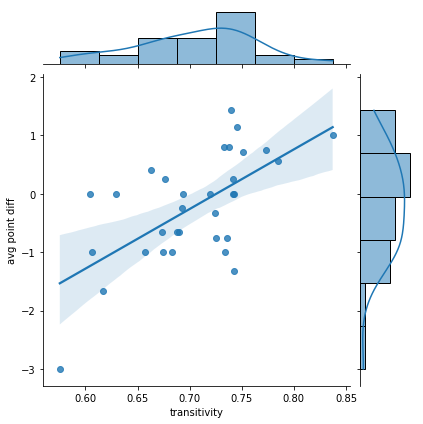

In [11]:
sb.jointplot("transitivity", "avg point diff", data=team_metrics, kind='reg');

# Team Analysis
Create metrics and analysis for any given team.

Create features for last names to use for plots with the passes dataframe.

In [12]:
# create field with just last names
passes['passer'] = passes['player'].str.split().str[-1]
passes['recipient'] = passes['pass_recipient'].str.split().str[-1]
#passes.head()

Create a feature for forward pass distance in the passes dataframe.

In [13]:
# create field for forward pass distance
passes['downfield_dist'] = passes['pass_length'] * np.cos(passes['pass_angle'])

### Build Team Passing Data

In [14]:
team = "Panama"

# Create passing df for a given team
team_df = passes[passes.team.eq(team)]
print("Full Count:", len(team_df.index))

# Use to manually create list
#print(team_df['player'].unique())

# Create list of starters excluding Goal Keeper
Brazil = ['Fágner Conserva Lemos', 'Thiago Emiliano da Silva', 'João Miranda de Souza Filho', 
          'Filipe Luís Kasmirski', 'Carlos Henrique Casimiro', 'José Paulo Bezzera Maciel Júnior', 
          'Willian Borges da Silva', 'Philippe Coutinho Correia', 'Neymar da Silva Santos Junior', 
          'Gabriel Fernando de Jesus']

Panama = ['Adolfo Abdiel Machado', 'Román Aureliano Torres Morcillo', 
          'Fidel Escobar Mendieta', 'Luis Carlos Ovalle Victoria',
          'Gabriel Enrique Gómez Girón', 'Aníbal Cesis Godoy',
          'Ricardo Guardia Avila', 'José Luis Rodríguez Francis',
          'Edgar Yoel Bárcenas Herrera', 'Gabriel Arturo Torres Tejada']

Full Count: 511


### Create List of Edges
Build a list of all passes which will be used to define the edges in a weighted directed graph.

In [15]:
edges = []
for index, row in team_df.iterrows():
    if row.player in Panama and row.pass_recipient in Panama:
        edges.append((row.player, row.pass_recipient))
    else:
        pass

### Build Graph from Edges
Use NetworkX to create directed and weighted graph.

In [16]:
graph = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(edges).items())
#print(*graph.edges(data=True), sep='\n')

### Print Team Metrics
- **Density:** Network density gives you a quick sense of how closely knit your network is.  This is simply the ratio of actual edges in the network to all possible edges in the network.
- **Diameter:** Provides a sense of the network’s overall size, the distance from one end of the network to another. This is the longest of all shortest paths.
- **Triadic Closure / Transitivity:** Transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Triadic closure supposes that if two people know the same person, they are likely to know each other. 

In [17]:
print(team)
print("Total number of nodes: ", int(graph.number_of_nodes())) 
print("Total number of edges: ", int(graph.number_of_edges())) 
print("Network density:", nx.density(graph))
print("Network diameter:", nx.diameter(graph))
print("Triadic closure:", nx.transitivity(graph))

# # Plot basic graph
#nx.draw_networkx(graph) 

Panama
Total number of nodes:  10
Total number of edges:  63
Network density: 0.7
Network diameter: 2
Triadic closure: 0.7651933701657458


###  Calculate Network Metrics by Player
- **Closeness Centrality:** *Indicates how close a player is to all other players.*  Avg of shortest path length from given player to all other players.
- **Betweenness Centrality:** *Measures how important a player is to the shortest paths through the network.*  To compute betweenness for a node N, we select a pair of nodes and find all the shortest paths between those nodes. Then we compute the fraction of those shortest paths that include node N. If there were five shortest paths between a pair of nodes, and three of them went through node N, then the fraction would be 3÷5=0.6. We repeat this process for every pair of nodes in the network. We then add up the fractions we computed, and this is the betweenness centrality for node N.
- **Eigenvector centrality:** *a more sophisticated view of centrality.* a player with few connections could have a very high eigenvector centrality if those few connections were to other very well-connected players.
- **Net Score:** *combination of betweeness and centrality* calculated as ev_centrallity + (5 * betweenness)

In [18]:
# Create dataframe to hold player metrics for given team
player_metrics = pd.DataFrame(columns=['team', 'player', 'degree', 'closeness', 'betweenness', 'ev_centrality', 'net_score' ])

# Build metrics for each player
for player in list(graph.nodes()):
    #print(player)
    player_metrics = player_metrics.append({'team' : team, 'player' : player, 
                                            'degree' : graph.degree(player), 
                                            'closeness': nx.closeness_centrality(graph)[player], 
                                            'betweenness': nx.betweenness_centrality(graph)[player], 
                                            'ev_centrality': nx.eigenvector_centrality(graph)[player],
                                            'net_score': nx.eigenvector_centrality(graph)[player] + (5*nx.betweenness_centrality(graph)[player] )},
                                            ignore_index=True)

player_metrics

,team,player,degree,closeness,betweenness,ev_centrality,net_score
0,Panama,Fidel Escobar Mendieta,14,0.900000,0.064352,0.273453,0.595212
1,Panama,Aníbal Cesis Godoy,16,0.900000,0.056481,0.588133,0.870541
2,Panama,Gabriel Enrique Gómez Girón,16,0.900000,0.049537,0.425801,0.673486
3,Panama,Román Aureliano Torres Morcillo,10,0.692308,0.008333,0.184990,0.226656
4,Panama,José Luis Rodríguez Francis,15,0.818182,0.106713,0.333220,0.866785
5,Panama,Edgar Yoel Bárcenas Herrera,16,0.818182,0.064120,0.432725,0.753327
6,Panama,Gabriel Arturo Torres Tejada,9,0.600000,0.000000,0.102037,0.102037
7,Panama,Luis Carlos Ovalle Victoria,6,0.642857,0.000000,0.055351,0.055351
8,Panama,Adolfo Abdiel Machado,11,0.750000,0.010648,0.174237,0.227478
9,Panama,Ricardo Guardia Avila,13,0.818182,0.014815,0.147224,0.221298


In [19]:
player_metrics.describe().T

,count,mean,std,min,25%,50%,75%,max
closeness,10.0,0.783971,0.109145,0.600000,0.706731,0.818182,0.879545,0.900000
betweenness,10.0,0.037500,0.035938,0.000000,0.008912,0.032176,0.062211,0.106713
ev_centrality,10.0,0.271717,0.170522,0.055351,0.153977,0.229221,0.402656,0.588133
net_score,10.0,0.459217,0.323399,0.055351,0.222637,0.411345,0.733367,0.870541


### Add Node Attributes for Custom Plots
Add node attributes for avg pass length, position_id, and downfield_dist to be used in building out custome graph plots.

In [20]:
# Create scale based on position -- defensive backs are lower nums and forwards are higher
passes['position_scale'] = passes.apply(lambda x: position_dict[x.position], axis=1)

# add node attributes for avg pass length, position_id, and downfield_dist
for p in list(graph.nodes()):
    #print(player)
    graph.node[p]['pass_length'] = passes[passes.player.eq(p)].pass_length.mean()
    graph.node[p]['position_scale'] = int((round(passes[passes.player.eq(p)].position_scale.mean())/5.0)*5.0)
    graph.node[p]['downfield_distance'] = passes[passes.player.eq(p)].downfield_dist.mean()
    graph.node[p]['ev_centrality'] = player_metrics[player_metrics.player.eq(p)].ev_centrality.mean()
    graph.node[p]['net_score'] = player_metrics[player_metrics.player.eq(p)].net_score.mean()
    graph.node[p]['degree'] = player_metrics[player_metrics.player.eq(p)].degree.mean()
    
print('pass_length', [nx.get_node_attributes(graph, 'pass_length')[v] for v in graph])
print('position_scale', [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph])
print('downfield_distance', [nx.get_node_attributes(graph, 'downfield_distance')[v] for v in graph])
print('pass_length', [nx.get_node_attributes(graph, 'pass_length')[v] for v in graph])

pass_length [26.76710700454545, 19.080754680000002, 23.56360541, 27.686281548387097, 16.132100366666666, 16.16225156511628, 13.560879, 23.360591833333334, 18.5525266, 22.4693775375]
position_scale [11, 15, 15, 10, 25, 25, 25, 10, 10, 16]
downfield_distance [14.54545438980685, 1.3076922474783697, 5.616666612569956, 19.290322597879825, -1.1944443248124104, 1.581395368006536, -3.3333330533761565, 9.833333743542143, 8.466666447963963, 7.437499681941895]
pass_length [26.76710700454545, 19.080754680000002, 23.56360541, 27.686281548387097, 16.132100366666666, 16.16225156511628, 13.560879, 23.360591833333334, 18.5525266, 22.4693775375]


Text(0,0.5,'EV Centrality')

<Figure size 1080x1080 with 0 Axes>

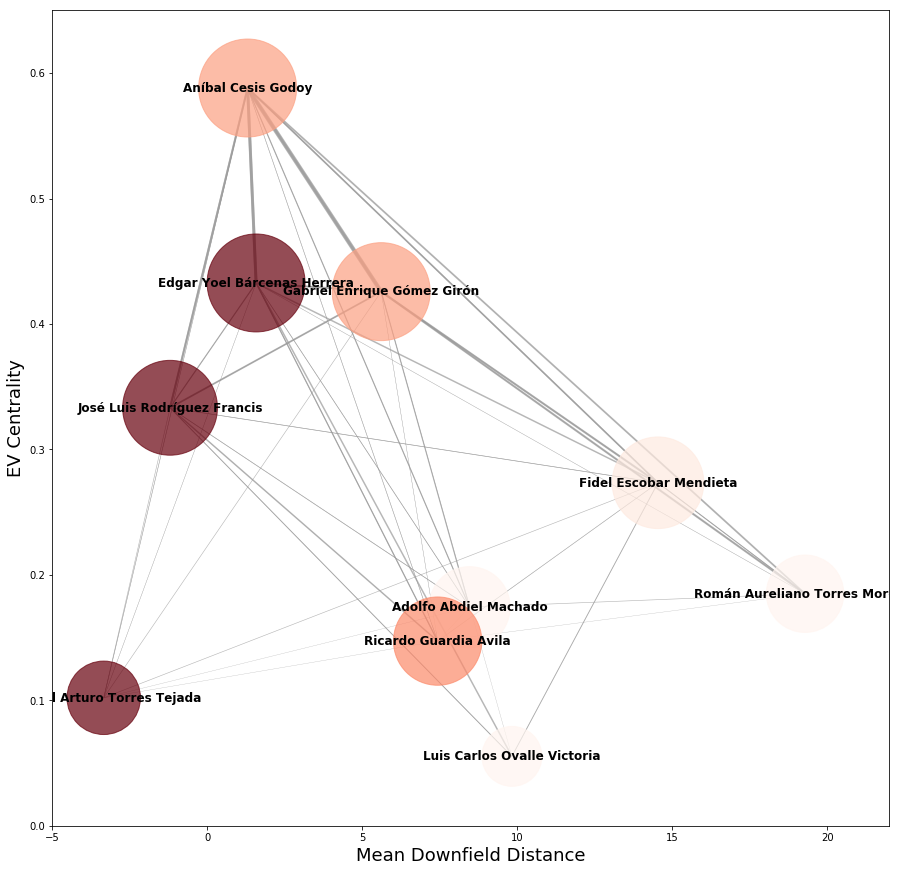

In [21]:
pos = nx.spring_layout(graph)
for p in list(graph.nodes()):
  
    # x pos
    pos[p][0] = passes[passes.player.eq(p)].downfield_dist.mean()
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].ev_centrality.mean()

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15 ))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [600*nx.get_node_attributes(graph, 'degree')[v] for v in graph]

edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]

nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Reds, ax=ax) 

# off axes
plt.axis('on')
plt.ylim(0, .65)
plt.xlim(-5, 22)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Mean Downfield Distance', fontsize=18) 
plt.ylabel('EV Centrality', fontsize=18) 

Text(0,0.5,'Betweenness')

<Figure size 1080x1080 with 0 Axes>

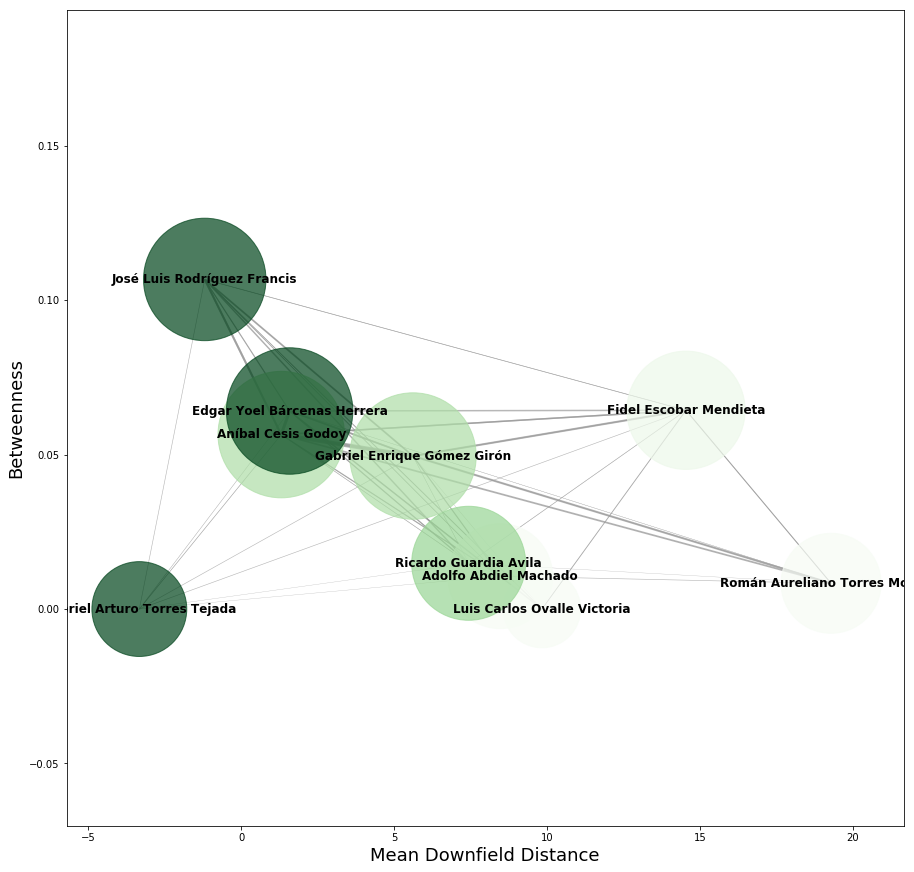

In [32]:
for p in list(graph.nodes()):

    # x pos
    pos[p][0] = passes[passes.player.eq(p)].downfield_dist.mean()
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].betweenness.mean()

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [1000*nx.get_node_attributes(graph, 'degree')[v] for v in graph]


edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]


nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Greens, ax=ax) 

# off axes
plt.axis('on')
#plt.ylim(0, .008)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Mean Downfield Distance', fontsize=18) 
plt.ylabel('Betweenness', fontsize=18) 

Text(0,0.5,'EV Centrality')

<Figure size 1080x1080 with 0 Axes>

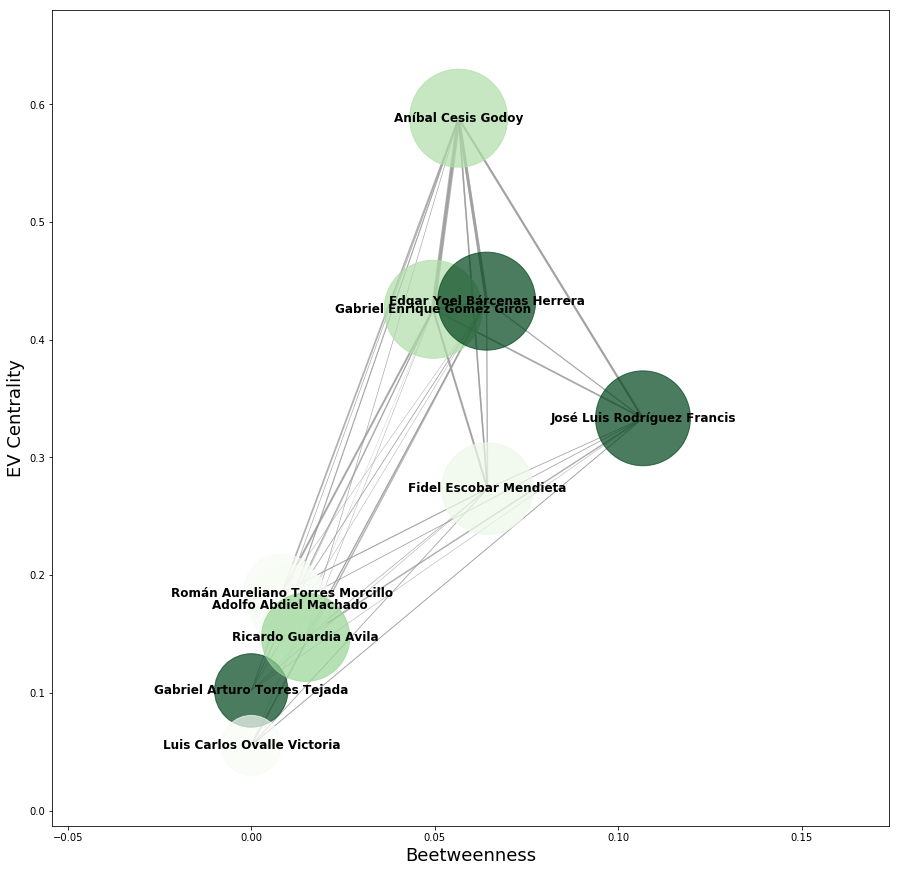

In [33]:
for p in list(graph.nodes()):

    # x pos
    pos[p][0] = player_metrics[player_metrics.player.eq(p)].betweenness
    # y pos
    pos[p][1] = player_metrics[player_metrics.player.eq(p)].ev_centrality

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(figsize=(15, 15))

# using degree for each node
node_color = [nx.get_node_attributes(graph, 'position_scale')[v] for v in graph]

node_size = [600*nx.get_node_attributes(graph, 'degree')[v] for v in graph]


edge_width = [.3*graph[u][v]['weight'] for u,v in graph.edges()]


nx.draw_networkx(graph, pos, node_size = node_size,  
                 node_color = node_color, alpha = 0.7, arrows=False,
                 with_labels = True, width = edge_width,font_size=12, font_color="black", font_weight="bold",
                 edge_color ='.6', cmap = plt.cm.Greens, ax=ax) 

# off axes
plt.axis('on')
#plt.xlim(0, .008)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel('Beetweenness', fontsize=18) 
plt.ylabel('EV Centrality', fontsize=18) 